# MLP
Mean RCI over 14 cell lines.

This notebook uses
lncRNA, canonical, no middle-exclusion, GMM, learning module.

Save the models.

In [1]:
SEED = 43
import tensorflow as tf
tf.random.set_seed(SEED) 
tf.keras.backend.set_floatx('float32')
import numpy as np
np.random.seed(SEED) 
from datetime import datetime
print(datetime.now())

2023-04-29 15:10:02.152034


In [2]:
import sys
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
    sys.path.append('/content/drive/My Drive/Colab Notebooks')
except:
    IN_COLAB = False
    DATA_DIR="/"
    MODEL_DIR="/"
print(DATA_DIR)
SAVE_MODEL_FILENAME = 'MLP'
SAVE_DESCRIM_FILENAME = 'GMM'
LOAD_MODEL_FILENAME = None # 'MLP.0.0..model'
LOAD_DESCRIM_FILENAME = None # 'GMM.0.0.pickle'

GPU device not found
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from learning import DataLoader, CrossValidator, Separator, ModelBuilder

K=5
ALPHABET=4**K + 1
EPOCHS=300 
EMBED_DIMEN = 4 # arbitrary hyperparameter
RCI_THRESHOLD_MECHANISM = 'RCI_GMM'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
RCI_THRESHOLD_VALUE = -1  # use -1 for lncRNA, use 0 for mRNA
BREAK = False   # optionally break after first fold
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
MIDDLE_LOW          = -2   # -2 for lncRNA, -1 for mRNA
MIDDLE_HIGH         = 0    #  0 for lncRNA, +1 for mRNA

REPEATS = 2
FOLDS = 5

Python 3.10.11
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.all_cell_lines.csv'
RCI_FILE_TEST  = None # 'test.lncRNA_RCI.all_cell_lines.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()
EXCLUSIONS = [1]  # H1.hESC   
print('Exclusions',EXCLUSIONS)

Exclusions [1]


In [6]:
from keras import models
import pickle

def save_model(model, discriminator, filename1, filename2):
    filepath = MODEL_DIR + filename1
    model.save(filepath)
    print('Saved model 1 to',filepath)
    filepath = MODEL_DIR + filename2
    pickle.dump(discriminator, open(filepath, 'wb'))
    print('Saved model 2 to',filepath)

def load_model(filename1, filename2):
    filepath = MODEL_DIR + filename1
    model = keras.models.load_model(filepath)
    print('Loaded model 1 from',filepath)
    filepath = MODEL_DIR + filename2
    discriminator = pickle.load(open(filepath, 'rb'))        
    print('Loaded model 2 from',filepath)
    return model, discriminator
        

2023-04-29 15:10:05.152010
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.all_cell_lines.csv
Number of RCI values loaded 4372
Num RCI: 4372
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4372 sequences.

Training # 1 1
2023-04-29 15:10:15.161910
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
Discriminator is GMM
Means [0.01895632248704553, -2.4676465749012593]
Variances [1.51869398 2.16274189]
Priors [0.57192624 0.42807376]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2119:1378 60.59%
Computed class weights: {0: 1.2688679245283019, 1: 0.8251533742331288}
Valid 1:0 509:366 58.17%
FIT


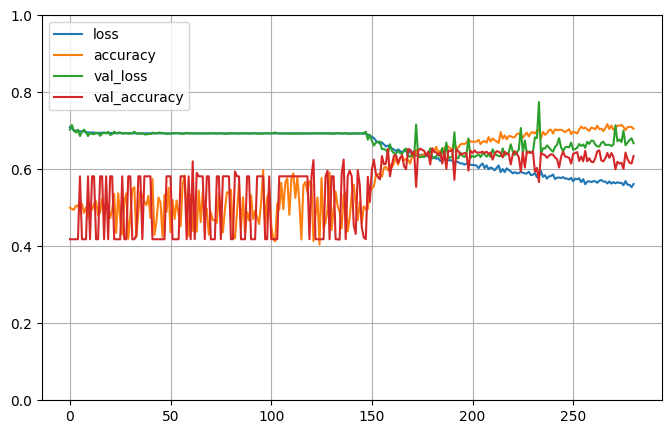

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP.1.1.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM.1.1.pickle

Testing # 1 1
2023-04-29 15:13:42.037941
PREDICT
Test 1:0 509:366 58.17%
Predict 1:0 591:284 67.54%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.557394 mean 0.15186898 std
Range of scores: 0.07583416 to 0.8460029
Score threshold 0.5
Confusion matrix
 [[174 192]
 [110 399]]
Normalized matrix
 [[0.19885714 0.21942857]
 [0.12571429 0.456     ]]
Extreme scores correct, pos:neg 195 61
Extreme scores incorrect pos:neg 71 24


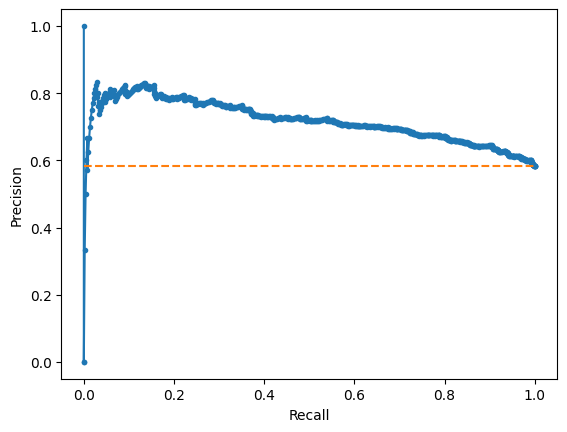

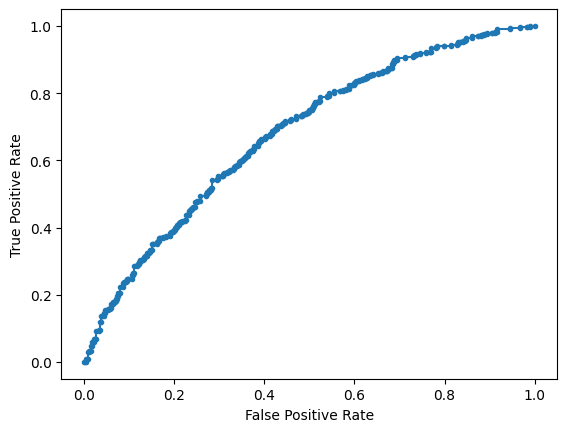

Accuracy: 65.49% Precision: 67.51% Recall: 78.39%
F1: 72.55% MCC: 0.2732
AUPRC: 71.73% AUROC: 67.81%
 accuracy [65.48571428571428]
 precision [67.51269035532995]
 recall [78.38899803536346]
 F1 [72.54545454545456]
 MCC [0.2731798943273938]
 AUPRC [71.72693061806062]
 AUROC [67.80626321835379]

Training # 1 2
2023-04-29 15:13:42.995315
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
Discriminator is GMM
Means [-0.01751735211322688, -2.4589772079629304]
Variances [1.47265327 2.26806313]
Priors [0.56598974 0.43401026]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2105:1392 60.19%
Computed class weights: {0: 1.2561063218390804, 1: 0.8306413301662707}
Valid 1:0 530:345 60.57%
FIT


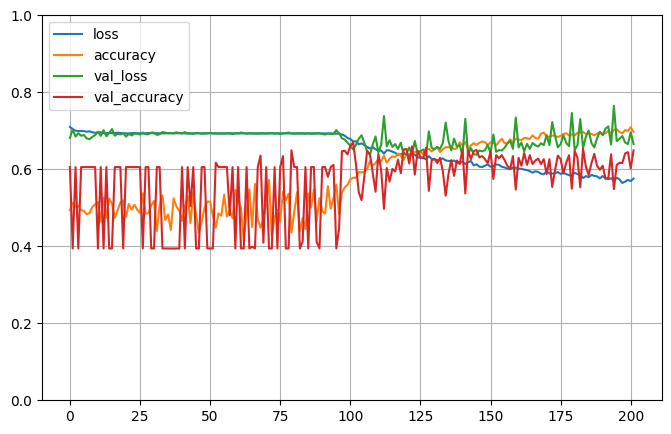

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP.1.2.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM.1.2.pickle

Testing # 1 2
2023-04-29 15:15:41.355389
PREDICT
Test 1:0 530:345 60.57%
Predict 1:0 689:186 78.74%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.5523911 mean 0.06956943 std
Range of scores: 0.35049248 to 0.75657934
Score threshold 0.5
Confusion matrix
 [[121 224]
 [ 65 465]]
Normalized matrix
 [[0.13828571 0.256     ]
 [0.07428571 0.53142857]]
Extreme scores correct, pos:neg 63 0
Extreme scores incorrect pos:neg 22 0


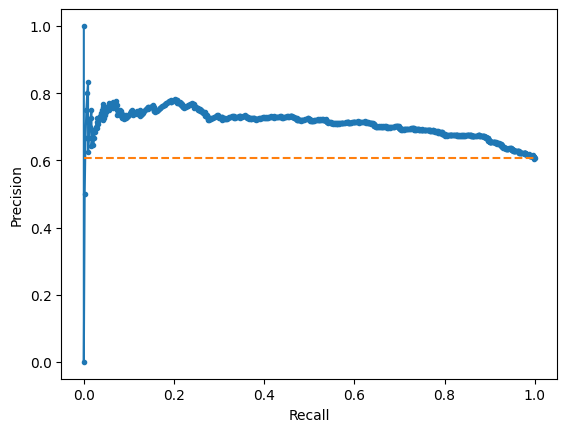

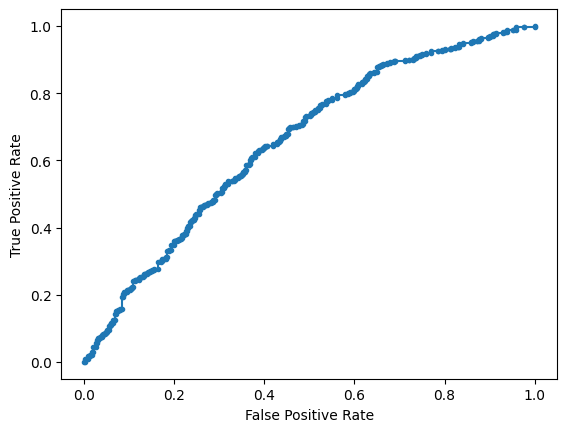

Accuracy: 66.97% Precision: 67.49% Recall: 87.74%
F1: 76.29% MCC: 0.2724
AUPRC: 70.96% AUROC: 65.48%
 accuracy [66.97142857142858]
 precision [67.48911465892597]
 recall [87.73584905660378]
 F1 [76.29204265791631]
 MCC [0.2724423138788547]
 AUPRC [70.95784248487487]
 AUROC [65.48208914410718]

Training # 1 3
2023-04-29 15:15:41.949786
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
Discriminator is GMM
Means [-2.514439033073329, 0.029096310640761725]
Variances [2.24081997 1.52484632]
Priors [0.42515337 0.57484663]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2129:1369 60.86%
Computed class weights: {0: 1.2775748721694669, 1: 0.8215124471582903}
Valid 1:0 518:356 59.27%
FIT


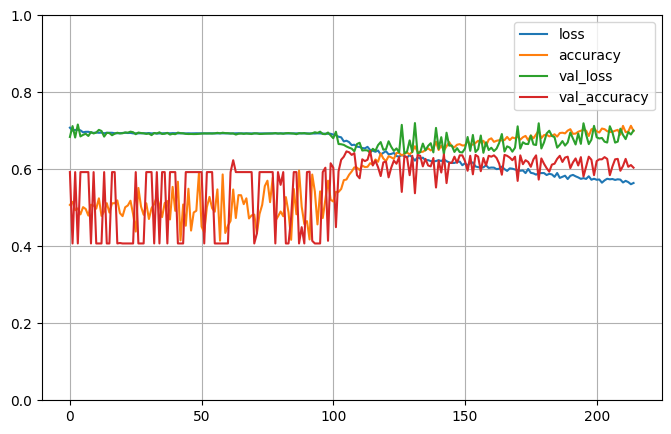

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP.1.3.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM.1.3.pickle

Testing # 1 3
2023-04-29 15:17:51.377058
PREDICT
Test 1:0 518:356 59.27%
Predict 1:0 654:220 74.83%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.57060844 mean 0.105013944 std
Range of scores: 0.23227166 to 0.8497444
Score threshold 0.5
Confusion matrix
 [[134 222]
 [ 86 432]]
Normalized matrix
 [[0.15331808 0.25400458]
 [0.09839817 0.49427918]]
Extreme scores correct, pos:neg 150 9
Extreme scores incorrect pos:neg 50 2


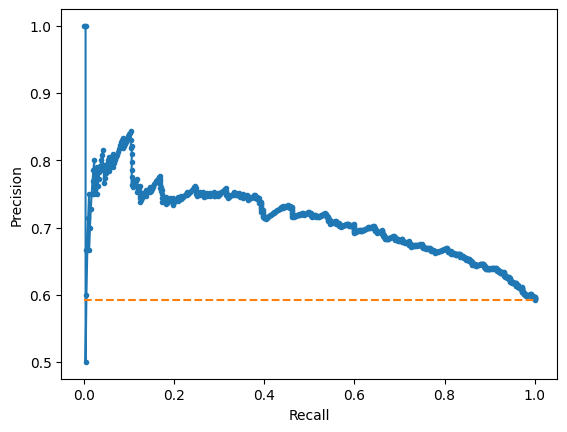

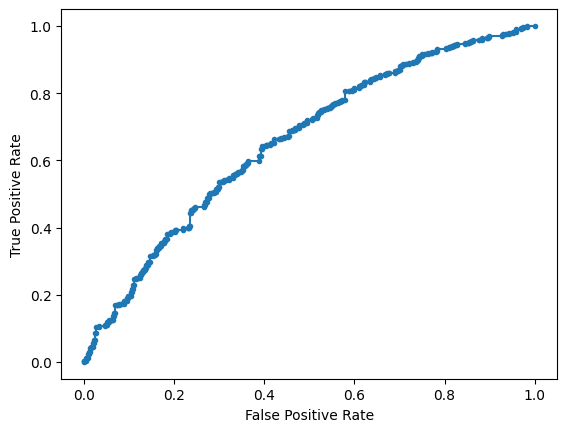

Accuracy: 64.76% Precision: 66.06% Recall: 83.40%
F1: 73.72% MCC: 0.2382
AUPRC: 71.13% AUROC: 65.69%
 accuracy [64.75972540045767]
 precision [66.05504587155964]
 recall [83.3976833976834]
 F1 [73.72013651877133]
 MCC [0.23817537475488854]
 AUPRC [71.12905412681225]
 AUROC [65.68695501279771]

Training # 1 4
2023-04-29 15:17:52.181827
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
Discriminator is GMM
Means [-2.490992700434666, 0.030416965156384555]
Variances [2.13989044 1.49976412]
Priors [0.43788827 0.56211173]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2067:1431 59.09%
Computed class weights: {0: 1.2222222222222223, 1: 0.8461538461538461}
Valid 1:0 537:337 61.44%
FIT


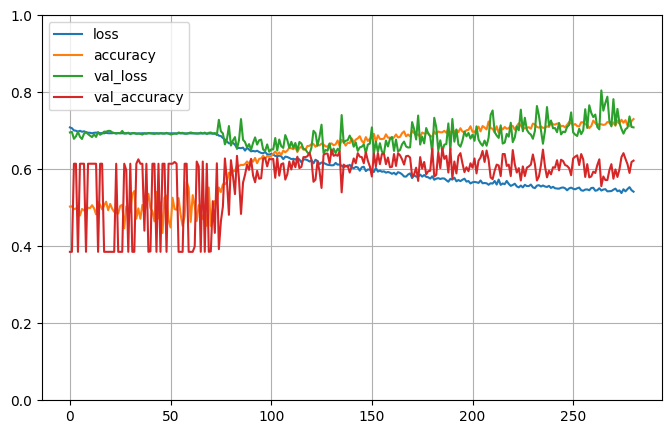

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP.1.4.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM.1.4.pickle

Testing # 1 4
2023-04-29 15:20:33.368431
PREDICT
Test 1:0 537:337 61.44%
Predict 1:0 670:204 76.66%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.61684656 mean 0.18296304 std
Range of scores: 0.02426572 to 0.92421484
Score threshold 0.5
Confusion matrix
 [[119 218]
 [ 85 452]]
Normalized matrix
 [[0.13615561 0.24942792]
 [0.097254   0.51716247]]
Extreme scores correct, pos:neg 301 53
Extreme scores incorrect pos:neg 116 23


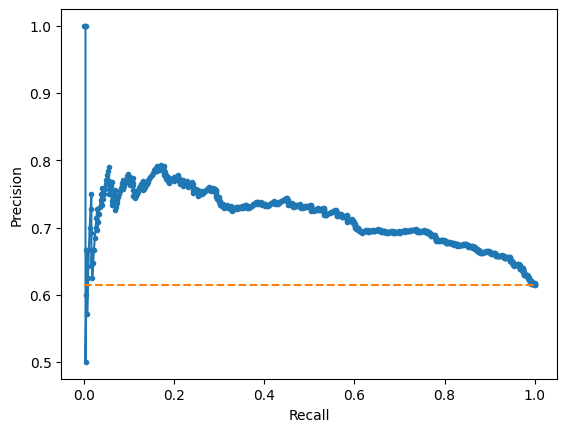

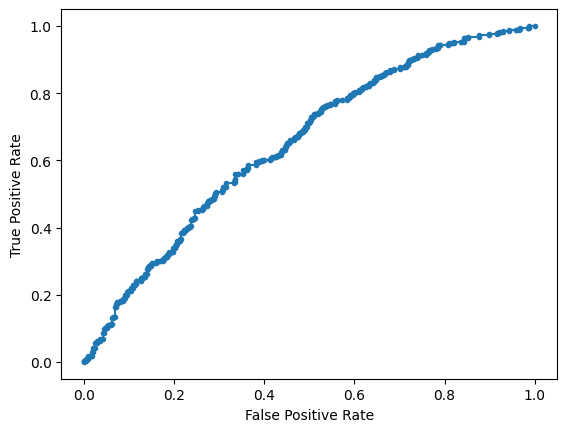

Accuracy: 65.33% Precision: 67.46% Recall: 84.17%
F1: 74.90% MCC: 0.2242
AUPRC: 71.60% AUROC: 64.84%
 accuracy [65.33180778032036]
 precision [67.46268656716417]
 recall [84.17132216014897]
 F1 [74.89643744821873]
 MCC [0.22418321603977365]
 AUPRC [71.60496052712297]
 AUROC [64.84204477009875]

Training # 1 5
2023-04-29 15:20:33.999546
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
Discriminator is GMM
Means [-2.516204018113696, -0.002334896572943434]
Variances [2.21247477 1.49223983]
Priors [0.43165415 0.56834585]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2107:1391 60.23%
Computed class weights: {0: 1.2573687994248741, 1: 0.8300901756051258}
Valid 1:0 539:335 61.67%
FIT


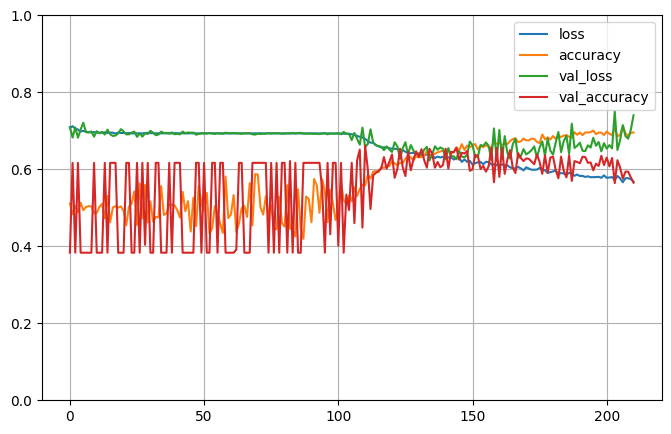

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP.1.5.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM.1.5.pickle

Testing # 1 5
2023-04-29 15:22:40.649564
PREDICT
Test 1:0 539:335 61.67%
Predict 1:0 669:205 76.54%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.5416941 mean 0.056897357 std
Range of scores: 0.40244415 to 0.75929606
Score threshold 0.5
Confusion matrix
 [[122 213]
 [ 83 456]]
Normalized matrix
 [[0.1395881  0.24370709]
 [0.09496568 0.52173913]]
Extreme scores correct, pos:neg 37 0
Extreme scores incorrect pos:neg 13 0


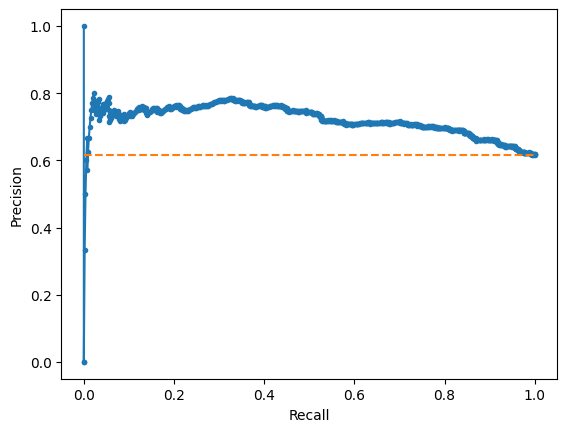

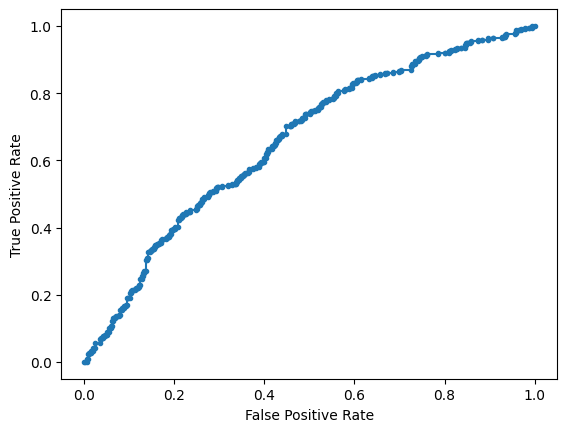

Accuracy: 66.13% Precision: 68.16% Recall: 84.60%
F1: 75.50% MCC: 0.2412
AUPRC: 72.02% AUROC: 65.58%
 accuracy [66.13272311212815]
 precision [68.16143497757847]
 recall [84.60111317254174]
 F1 [75.49668874172185]
 MCC [0.24117891382157375]
 AUPRC [72.02460117519112]
 AUROC [65.57915432115858]

Training # 2 1
2023-04-29 15:22:41.255568
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
Discriminator is GMM
Means [0.0521959698133772, -2.431014699880133]
Variances [1.47906411 2.26296184]
Priors [0.55520509 0.44479491]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2054:1443 58.74%
Computed class weights: {0: 1.2117117117117118, 1: 0.8512658227848101}
Valid 1:0 503:372 57.49%
FIT


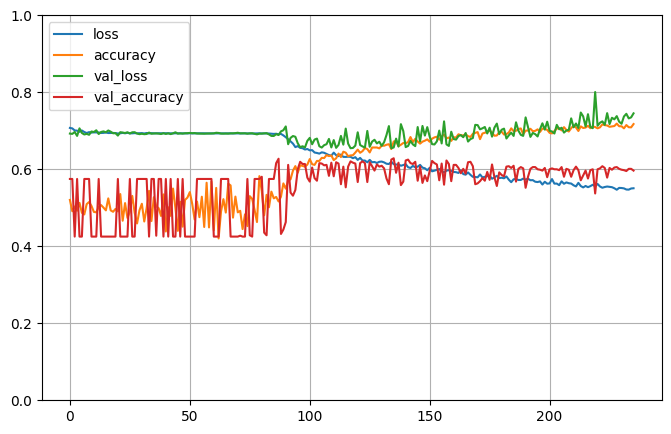

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP.2.1.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM.2.1.pickle

Testing # 2 1
2023-04-29 15:25:07.319059
PREDICT
Test 1:0 503:372 57.49%
Predict 1:0 592:283 67.66%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.56044644 mean 0.16092719 std
Range of scores: 0.029977452 to 0.8802928
Score threshold 0.5
Confusion matrix
 [[165 207]
 [118 385]]
Normalized matrix
 [[0.18857143 0.23657143]
 [0.13485714 0.44      ]]
Extreme scores correct, pos:neg 196 59
Extreme scores incorrect pos:neg 84 34


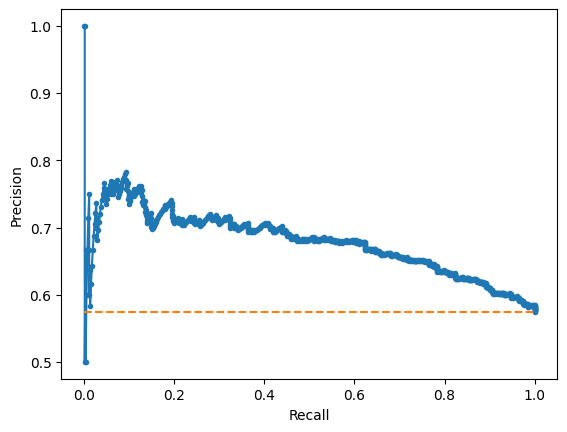

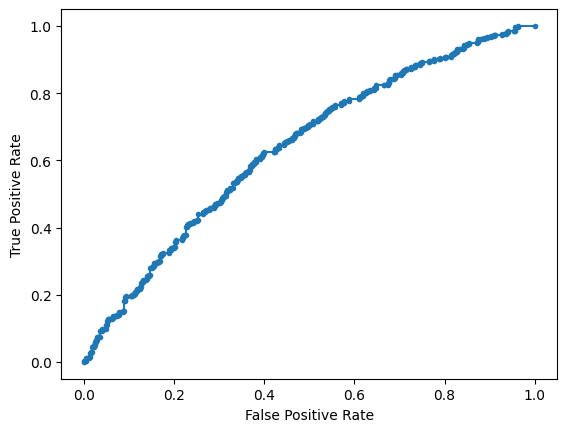

Accuracy: 62.86% Precision: 65.03% Recall: 76.54%
F1: 70.32% MCC: 0.2208
AUPRC: 67.80% AUROC: 63.81%
 accuracy [62.857142857142854]
 precision [65.03378378378379]
 recall [76.54075546719682]
 F1 [70.31963470319636]
 MCC [0.2208290053821925]
 AUPRC [67.79925256797618]
 AUROC [63.81068428140833]

Training # 2 2
2023-04-29 15:25:07.937036
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
Discriminator is GMM
Means [-2.509720364239361, -0.021926325901453603]
Variances [2.21515531 1.49808196]
Priors [0.42412019 0.57587981]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]
Train 1:0 2140:1357 61.20%
Computed class weights: {0: 1.2885040530582166, 1: 0.8170560747663551}
Valid 1:0 533:342 60.91%
FIT


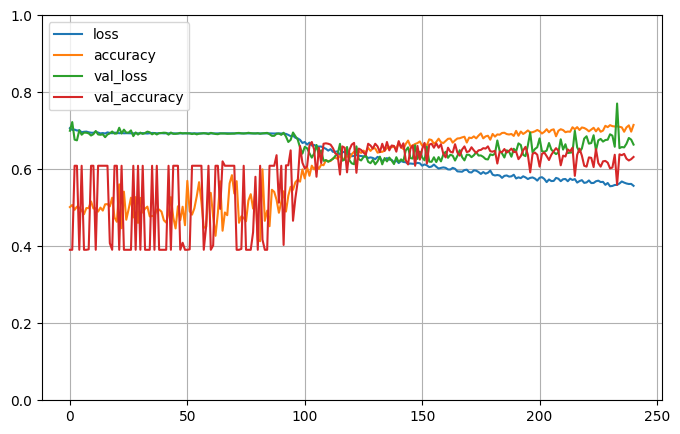

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP.2.2.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM.2.2.pickle

Testing # 2 2
2023-04-29 15:27:28.630850
PREDICT
Test 1:0 533:342 60.91%
Predict 1:0 585:290 66.86%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.56104267 mean 0.16651754 std
Range of scores: 0.06800184 to 0.88819075
Score threshold 0.5
Confusion matrix
 [[173 169]
 [117 416]]
Normalized matrix
 [[0.19771429 0.19314286]
 [0.13371429 0.47542857]]
Extreme scores correct, pos:neg 228 78
Extreme scores incorrect pos:neg 68 25


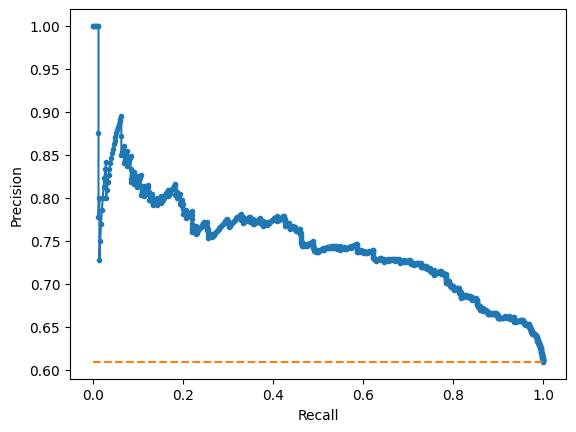

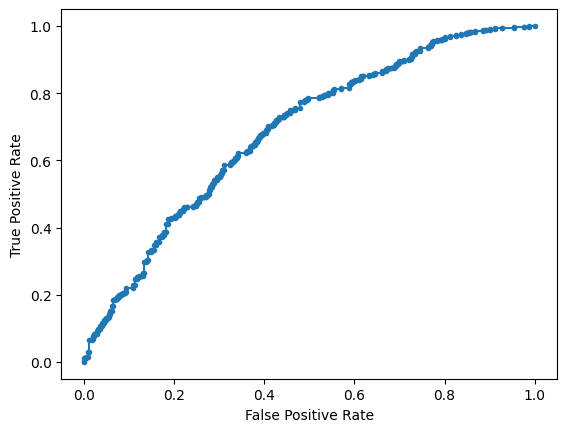

Accuracy: 67.31% Precision: 71.11% Recall: 78.05%
F1: 74.42% MCC: 0.2968
AUPRC: 74.78% AUROC: 68.59%
 accuracy [67.31428571428572]
 precision [71.11111111111111]
 recall [78.04878048780488]
 F1 [74.4186046511628]
 MCC [0.29680780173121135]
 AUPRC [74.78125975233937]
 AUROC [68.58946929550267]

Training # 2 3
2023-04-29 15:27:29.260310
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
Discriminator is GMM
Means [-0.0010792345809165678, -2.506383894781551]
Variances [1.49175817 2.1937748 ]
Priors [0.56415536 0.43584464]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2085:1413 59.61%
Computed class weights: {0: 1.237791932059448, 1: 0.8388489208633093}
Valid 1:0 547:327 62.59%
FIT


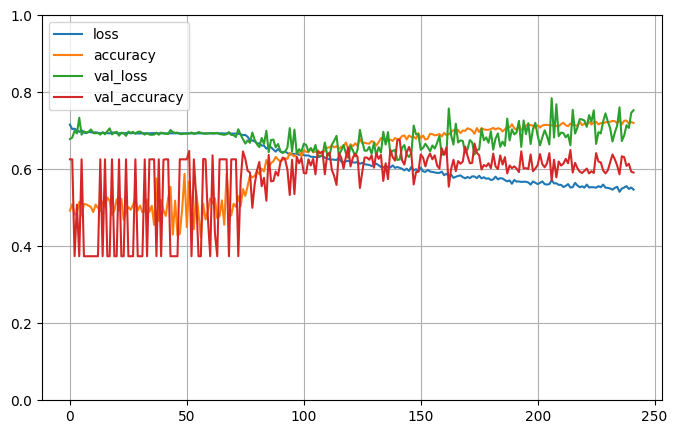

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP.2.3.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM.2.3.pickle

Testing # 2 3
2023-04-29 15:29:48.364036
PREDICT
Test 1:0 547:327 62.59%
Predict 1:0 671:203 76.77%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.60677934 mean 0.16194154 std
Range of scores: 0.07670619 to 0.87472355
Score threshold 0.5
Confusion matrix
 [[124 203]
 [ 79 468]]
Normalized matrix
 [[0.14187643 0.23226545]
 [0.09038902 0.53546911]]
Extreme scores correct, pos:neg 285 49
Extreme scores incorrect pos:neg 102 22


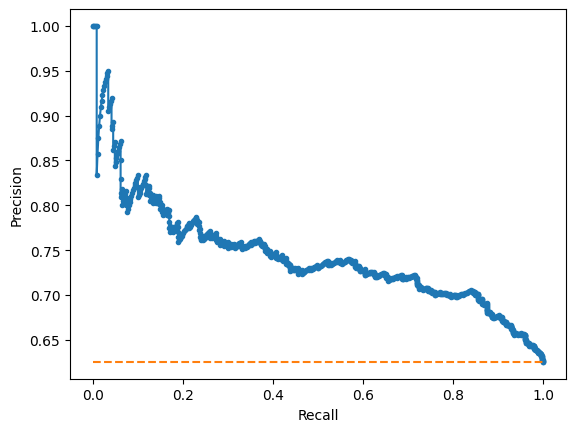

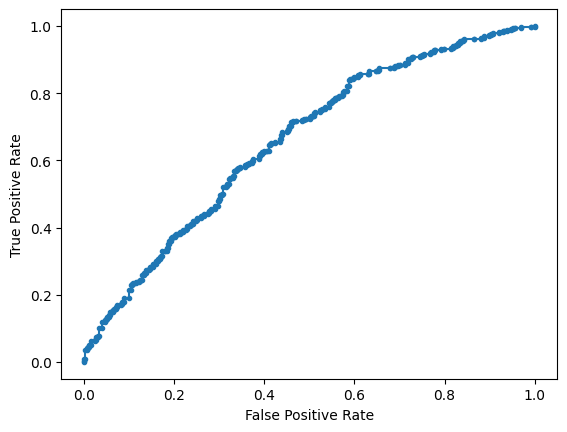

Accuracy: 67.73% Precision: 69.75% Recall: 85.56%
F1: 76.85% MCC: 0.2690
AUPRC: 74.37% AUROC: 65.81%
 accuracy [67.7345537757437]
 precision [69.74664679582713]
 recall [85.55758683729434]
 F1 [76.84729064039409]
 MCC [0.26904242391159783]
 AUPRC [74.37386323304843]
 AUROC [65.80570137922166]

Training # 2 4
2023-04-29 15:29:48.989676
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
Discriminator is GMM
Means [0.03253968800290521, -2.5153278244162682]
Variances [1.52535936 2.21411985]
Priors [0.57806904 0.42193096]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2142:1356 61.23%
Computed class weights: {0: 1.2898230088495575, 1: 0.8165266106442577}
Valid 1:0 508:366 58.12%
FIT


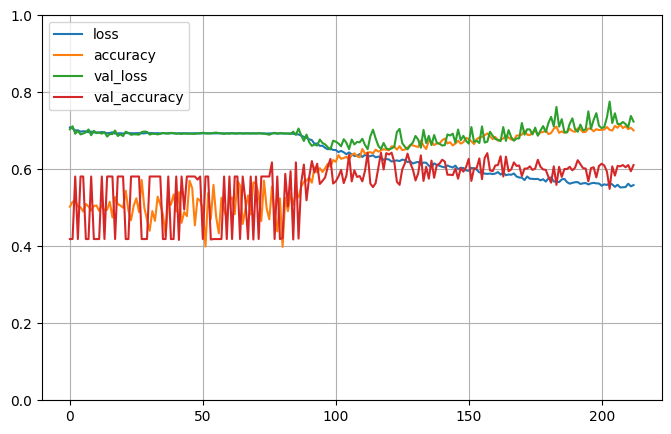

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP.2.4.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM.2.4.pickle

Testing # 2 4
2023-04-29 15:31:56.407988
PREDICT
Test 1:0 508:366 58.12%
Predict 1:0 570:304 65.22%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.5614855 mean 0.15139696 std
Range of scores: 0.13520251 to 0.9064693
Score threshold 0.5
Confusion matrix
 [[179 187]
 [125 383]]
Normalized matrix
 [[0.20480549 0.21395881]
 [0.14302059 0.4382151 ]]
Extreme scores correct, pos:neg 188 54
Extreme scores incorrect pos:neg 69 26


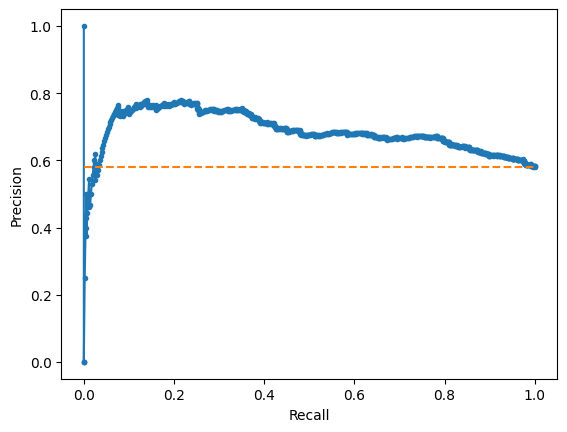

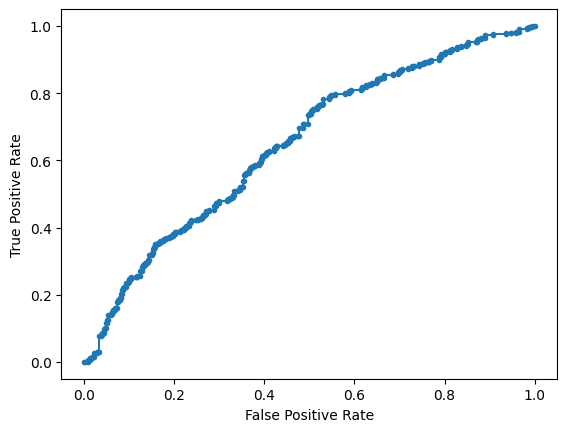

Accuracy: 64.30% Precision: 67.19% Recall: 75.39%
F1: 71.06% MCC: 0.2517
AUPRC: 68.51% AUROC: 64.81%
 accuracy [64.30205949656751]
 precision [67.19298245614034]
 recall [75.39370078740157]
 F1 [71.05751391465675]
 MCC [0.25172064317896065]
 AUPRC [68.50702358125629]
 AUROC [64.80626909341251]

Training # 2 5
2023-04-29 15:31:57.007439
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
Discriminator is GMM
Means [0.008651917707839183, -2.4692094011068564]
Variances [1.50276525 2.14900144]
Priors [0.56419911 0.43580089]
[-5, -4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3]
[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1]
Train 1:0 2068:1430 59.12%
Computed class weights: {0: 1.2230769230769232, 1: 0.8457446808510638}
Valid 1:0 543:331 62.13%
FIT


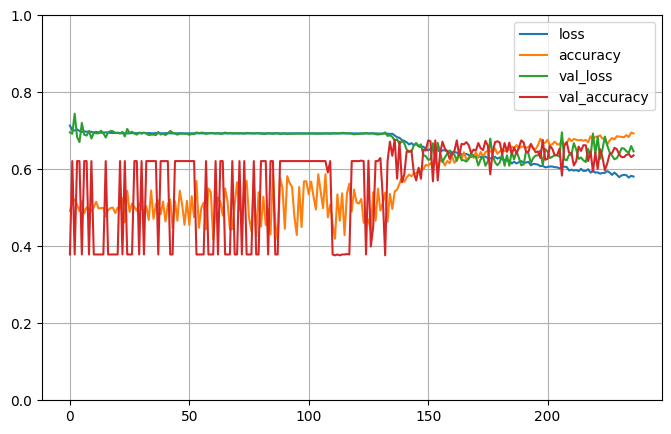

Saved model 1 to /content/drive/My Drive/data/Localization/Models/MLP.2.5.model
Saved model 2 to /content/drive/My Drive/data/Localization/Models/GMM.2.5.pickle

Testing # 2 5
2023-04-29 15:34:16.546248
PREDICT
Test 1:0 543:331 62.13%
Predict 1:0 693:181 79.29%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.5174947 mean 0.02262404 std
Range of scores: 0.46307668 to 0.6019679
Score threshold 0.5
Confusion matrix
 [[115 216]
 [ 66 477]]
Normalized matrix
 [[0.13157895 0.24713959]
 [0.07551487 0.54576659]]
Extreme scores correct, pos:neg 0 0
Extreme scores incorrect pos:neg 0 0


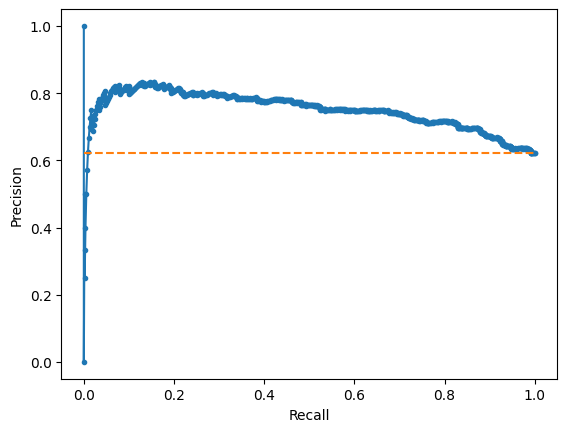

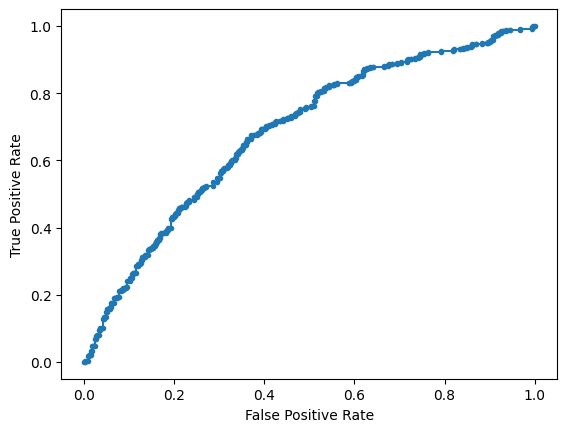

Accuracy: 67.73% Precision: 68.83% Recall: 87.85%
F1: 77.18% MCC: 0.2704
AUPRC: 74.90% AUROC: 68.40%
 accuracy [67.7345537757437]
 precision [68.83116883116884]
 recall [87.84530386740332]
 F1 [77.18446601941747]
 MCC [0.2703930472061965]
 AUPRC [74.89720998673437]
 AUROC [68.40368769229914]
2023-04-29 15:34:17.157226


In [7]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader(K,ALPHABET)
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader(K,ALPHABET)
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        builder = ModelBuilder(ALPHABET)
        cvdo = CrossValidator(EPOCHS,RCI_THRESHOLD_VALUE)
        cvdo.set_model_builder(builder)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.set_middle(FILTER_TEST,FILTER_TAILS_TEST,FILTER_MIDDLE_TEST,\
                                 FILTER_TRAIN,FILTER_TAILS_TRAIN,FILTER_MIDDLE_TRAIN,\
                                 MIDDLE_LOW,MIDDLE_HIGH)
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename1 = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                filename2 = f"{SAVE_DESCRIM_FILENAME}.{show_r}.{show_f}.pickle"
                model,discrim = cvdo.get_models()
                save_model(model,discrim,filename1,filename2)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            if LOAD_MODEL_FILENAME is not None:
                filename1 = LOAD_MODEL_FILENAME
                filename2 = LOAD_DESCRIM_FILENAME
                model, descrim = load_model(filename1, filename2)
                cvdo.set_models(model, descrim)
            else:
                cvdo.train_new_model(
                    train_allids,train_allseq,train_gene_to_rci,
                    None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [8]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 65.86% std 1.62
 precision mean 67.86% std 1.74
 recall mean 82.17% std 4.65
 F1 mean 74.28% std 2.37
 MCC mean 0.2558 std 0.0245
 AUPRC mean 71.78% std 2.43
 AUROC mean 66.08% std 1.63
 accuracy [[65.48571428571428], [66.97142857142858], [64.75972540045767], [65.33180778032036], [66.13272311212815], [62.857142857142854], [67.31428571428572], [67.7345537757437], [64.30205949656751], [67.7345537757437]]
 precision [[67.51269035532995], [67.48911465892597], [66.05504587155964], [67.46268656716417], [68.16143497757847], [65.03378378378379], [71.11111111111111], [69.74664679582713], [67.19298245614034], [68.83116883116884]]
 recall [[78.38899803536346], [87.73584905660378], [83.3976833976834], [84.17132216014897], [84.60111317254174], [76.54075546719682], [78.04878048780488], [85.55758683729434], [75.39370078740157], [87.84530386740332]]
 F1 [[72.54545454545456], [76.29204265791631], [73.72013651877133], [74.89643744821873], [75.49668874172185], [70.31963470319636], [74.4186